In [1]:
from metrices import Compute
from biomass import Biomassa
from helpers import price_function, source_data, score_csc_compute
from feeding_rate import feeding_rate

import numpy as np


f_uia, f_o2, f_temp, temperature = source_data(
    temp_suitable_min = 25,
    temp_suitable_max = 33,
    temp_optimal_min = 28,
    temp_optimal_max = 32,
    do_suitable_min = 4,
    do_suitable_max = 10,
    do_optimal_min = 6,
    do_optimal_max = 9,
    ua_suitable_min = 0.00,
    ua_suitable_max = 0.16,
    ua_optimal_min = 0.00,
    ua_optimal_max = 0.06,
)


csc_suitable_min = 0.00
csc_suitable_max = 5
csc_optimal_min = 0.00
csc_optimal_max = 3


In [2]:
T = 120
sr = 0.92

m = -np.log(sr)/T

weight = []
biomassa = []
revenue = []
population = []
f = price_function("data/fixed_price.csv")

cum_integral = 0
for i in range(T+1):
    if i == 0:
        score_csc = score_csc_compute(0/1000, 0.01, csc_suitable_min, csc_suitable_max, csc_optimal_max)
        feedRate = feeding_rate(0, float(temperature[temperature["DOC"]==i-1]["Suhu_s"]), 0)
        obj = Biomassa(0, i, 40, 0.05, 0.01, 100, sr, m, [0.1, 0.1, 0.1], [60, 70, 80], f_uia, f_o2, f_temp, score_csc, feedRate, cum_integral, final_doc=120)
        wt = obj.wt()
        nt = obj.population()
        biomass = obj.biomassa()
        constant_biomass = obj.biomassa_constant()
        cum_integral = obj._fr()
        ph = Compute(0, i, [60, 70, 80], wt, nt, biomass, 0, constant_biomass, 120)
    else:
        score_csc = score_csc_compute(biomassa[-1]/1000, 1000, csc_suitable_min, csc_suitable_max, csc_optimal_max)
        feedRate = feeding_rate(weight[-1], float(temperature[temperature["DOC"]==i-1]["Suhu_s"]), biomassa[-1]/1000)
        obj = Biomassa(i-1, i, 40, 0.05, 0.01, 100, sr, m, [0.1, 0.1, 0.1], [60, 70, 80], f_uia, f_o2, f_temp, score_csc, feedRate, cum_integral, 120)
        wt = obj.wt()
        nt = obj.population()
        biomass = obj.biomassa()
        constant_biomass = obj.biomassa_constant()
        cum_integral = obj._fr()
        ph = Compute(0, i, [60, 70, 80], wt, nt, biomass, biomassa[-1], constant_biomass, 120)

    weight.append(wt)
    biomassa.append(biomass)
    population.append(nt)
    revenue.append(ph.realized_revenue(f))

[0.1, 0.1, 0.1, 0.62]
[0.1, 0.1, 0.1, 0.62]


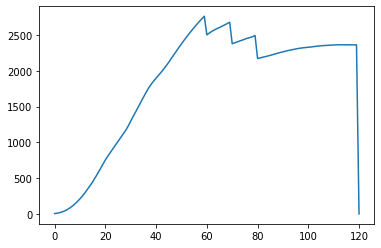

In [3]:
import matplotlib.pyplot as plt

x = list(range(T+1))
plt.plot(x, biomassa)

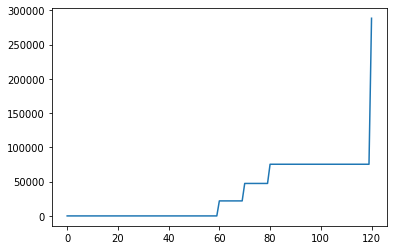

In [7]:
import numpy as np
cum_revenue = np.cumsum(revenue)
plt.plot(x, cum_revenue)

In [6]:
from scipy.integrate import quad

In [7]:
quad(lambda x: 2*x, 0, 5)

(25.0, 2.7755575615628914e-13)

In [9]:
quad(lambda x: 2*x, 0, 2)

(4.0, 4.440892098500626e-14)

In [10]:
quad(lambda x: 2*x, 2, 5)

(21.0, 2.3314683517128287e-13)

In [8]:
def fungsi():
    global variable
    variable = "a"

In [9]:
fungsi()

In [10]:
variable

'a'